## Introduction
This notebook analyzes the performance trends in the men's and women's **100-meter and 200-meter dash** in the Summer Olympic Games. The goal is to understand:

* How fast each medalists' time is compared to the model's **expected result** for that Olympic year
* Which medalist **overperformed** their expected result the most compared to all other competitors in the same event
* To **predict** the expected result for Gold, Silver, and Bronze in the 2024 Olympic Games 100-meter and 200-meter dash

This notebook was forked and based on Omri Goldstein's work on [Kaggle](https://www.kaggle.com/code/drgilermo/ahead-of-their-time). The updates to his notebook are the following:

* Added results from the Summer 2020 Olympic Games
* Plotted the data and fitted an exponential curve for **each medal**
* Removed outlier results from early Summer Olympic Games to better fit model
* **Predicted** the results for the 2024 men's and women's 100-meter and 200-meter dash

## Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# Load the CSV file
df = pd.read_csv('results_updated.csv')

# Display the first few rows of the dataframe
df.head()

,Gender,Event,Location,Year,Medal,Name,Nationality,Result
1,M,10000M Men,Rio,2016,G,Mohamed Farah,GBR,27:05.17
2,M,10000M Men,Rio,2016,S,Paul Kipngetich Tanui,KEN,27:05.64
3,M,10000M Men,Rio,2016,B,Tamirat Tola,ETH,27:06.26
4,M,10000M Men,Beijing,2008,G,Kenenisa Bekele,ETH,27:01.17
5,M,10000M Men,Beijing,2008,S,Sileshi Sihine,ETH,27:02.77


In [3]:
# Display information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2526 entries, 1 to 131
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Gender       2526 non-null   object
 1   Event        2526 non-null   object
 2   Location     2526 non-null   object
 3   Year         2526 non-null   int64 
 4   Medal        2526 non-null   object
 5   Name         2293 non-null   object
 6   Nationality  2526 non-null   object
 7   Result       2526 non-null   object
dtypes: int64(1), object(7)
memory usage: 177.6+ KB


# Data Cleaning and Preparation

In [4]:
# Clean and filter the data
df['Result'] = df['Result'].str.replace('h', ':')
event_data = df.copy()
event_data = event_data[event_data.Result != 'None']

# Convert 'Year' to int
event_data['Year'] = event_data['Year'].astype(int)

# Remove rows with NaN or inf values
event_data = event_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['Result'])

# Display the cleaned DataFrame
event_data

,Gender,Event,Location,Year,Medal,Name,Nationality,Result
1,M,10000M Men,Rio,2016,G,Mohamed Farah,GBR,27:05.17
2,M,10000M Men,Rio,2016,S,Paul Kipngetich Tanui,KEN,27:05.64
3,M,10000M Men,Rio,2016,B,Tamirat Tola,ETH,27:06.26
4,M,10000M Men,Beijing,2008,G,Kenenisa Bekele,ETH,27:01.17
5,M,10000M Men,Beijing,2008,S,Sileshi Sihine,ETH,27:02.77
...,...,...,...,...,...,...,...,...
127,W,Javelin Throw Women,Tokyo,2020,S,Maria Andrejczyk,POL,64.61
128,W,Javelin Throw Women,Tokyo,2020,B,Kelsey-Lee Barber,AUS,64.56
129,W,Heptathlon Women,Tokyo,2020,G,Nafi Thiam,BEL,6791
130,W,Heptathlon Women,Tokyo,2020,S,Anouk Vetter,NED,6689


## Function to plot sprint results with exponential fit

In [5]:
# Define the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_sprint_results(df, event_name, exponential_func, initial_params=(12, 1e-6, 1), maxfev=10000, omit_years=None):
    # Filter the dataframe for the specified event and clean the data
    sprint = df[df.Event == event_name]
    sprint = sprint[sprint.Result != 'None']
    sprint['Year'] = sprint.Year.apply(lambda x: int(x))
    sprint['Result'] = sprint.Result.apply(lambda x: float(x))

    # Remove rows with NaN or inf values
    sprint = sprint.replace([np.inf, -np.inf], np.nan).dropna(subset=['Result'])

    # Omit specified years if provided
    if omit_years is not None:
        sprint = sprint[~sprint['Year'].isin(omit_years)]

    # Prepare for plotting
    plt.figure(figsize=(10, 8))

    # Colors for medals
    colors = {'G': 'gold', 'S': 'silver', 'B': 'brown'}
    medals = ['G', 'S', 'B']
    labels = {'G': 'Gold', 'S': 'Silver', 'B': 'Bronze'}

    # Dictionary to store the fitted parameters for each medal
    fitted_params = {}

    # Plotting the data and fitting exponential curves for each medal
    for medal in medals:
        # Extract data for the current medal
        medal_data = sprint[sprint.Medal == medal]
        x = medal_data.Year.values
        y = medal_data.Result.values

        # Plot the data points
        plt.plot(x, y, 'o', color=colors[medal], markersize=10, alpha=0.4, label=labels[medal])

        # Check if there is enough data to fit the curve
        if len(x) > 2:
            try:
                # Fit the exponential function to the data
                popt, _ = curve_fit(exponential_func, x, y, p0=initial_params, maxfev=maxfev)
                fitted_params[medal] = popt  # Store the fitted parameters
                yy = exponential_func(np.unique(x), *popt)

                # Plot the fitted curve
                plt.plot(np.unique(x), yy, color=colors[medal])
            except RuntimeError as e:
                print(f"Could not fit data for medal {medal}. Error: {e}")
        else:
            print(f"Not enough data to fit for medal {medal}. Data points: {len(x)}")

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Result [sec]')
    plt.legend()
    plt.title(f'{event_name} Results by Medal')
    plt.show()

    return fitted_params, labels  # Return labels along with fitted_params

def predict_result(year, params):
    return exponential_func(year, *params)

In [6]:
# Function to calculate fitted parameters without plotting
def calculate_fitted_params(df, event_name, exponential_func, initial_params=(12, 1e-6, 1), maxfev=10000, omit_years=None):
    # Filter the dataframe for the specified event and clean the data
    sprint = df[df.Event == event_name]
    sprint = sprint[sprint.Result != 'None']
    sprint['Year'] = sprint.Year.apply(lambda x: int(x))
    sprint['Result'] = sprint.Result.apply(lambda x: float(x))

    # Remove rows with NaN or inf values
    sprint = sprint.replace([np.inf, -np.inf], np.nan).dropna(subset=['Result'])

    # Omit specified years if provided
    if omit_years is not None:
        sprint = sprint[~sprint['Year'].isin(omit_years)]

    # Colors for medals
    medals = ['G', 'S', 'B']
    labels = {'G': 'Gold', 'S': 'Silver', 'B': 'Bronze'}

    # Dictionary to store the fitted parameters for each medal
    fitted_params = {}

    # Calculate fitted parameters for each medal
    for medal in medals:
        # Extract data for the current medal
        medal_data = sprint[sprint.Medal == medal]
        x = medal_data.Year.values
        y = medal_data.Result.values

        # Check if there is enough data to fit the curve
        if len(x) > 2:
            try:
                # Fit the exponential function to the data
                popt, _ = curve_fit(exponential_func, x, y, p0=initial_params, maxfev=maxfev)
                fitted_params[medal] = popt  # Store the fitted parameters
            except RuntimeError as e:
                print(f"Could not fit data for medal {medal}. Error: {e}")
        else:
            print(f"Not enough data to fit for medal {medal}. Data points: {len(x)}")

    return fitted_params, labels

## Function to calculate expected result

In [7]:
# Calculate the expected result for a given event, medal type, and year
def get_expectation(fitted_params, medal, year):
    if medal in fitted_params:
        return exponential_func(year, *fitted_params[medal])
    else:
        return None

## Functions to calculate top performers for each event

In [8]:
# Function to calculate top performers
def calculate_top_performers(df, event_name, fitted_params, exclude_years=None):
    # Filter the dataframe for the specified event and clean the data
    sprint = df[df.Event == event_name].copy()
    sprint = sprint[sprint.Result != 'None'].copy()

    # Convert 'Year' and 'Result' columns to int and float respectively using loc to avoid the warning
    sprint.loc[:, 'Year'] = sprint['Year'].astype(int)
    sprint.loc[:, 'Result'] = sprint['Result'].astype(float)

    # Reset index after filtering and conversion
    sprint = sprint.reset_index(drop=True)
    
    # Exclude specific years if provided
    if exclude_years:
        sprint = sprint[~sprint.Year.isin(exclude_years)]

    # Initialize 'expectation' and calculate it for each row
    sprint['expectation'] = sprint.apply(lambda row: get_expectation(fitted_params, row['Medal'], row['Year']), axis=1)

    # Calculate ratio
    sprint['ratio'] = sprint['expectation'] / sprint['Result']

    # Sort and return the top 20 performers
    top_performers = sprint.sort_values('ratio', ascending=False).head(20)[['Name', 'Year', 'Medal', 'Result', 'expectation', 'ratio']].reset_index(drop=True)
    
    return top_performers

In [9]:
# Function to get top performers by medal without plotting
def get_top_performers_by_medal(df, event_name, top_n=10, exclude_years=None):
    # Get fitted parameters and labels
    fitted_params, labels = calculate_fitted_params(df, event_name, exponential_func, omit_years=exclude_years)

    # Calculate top performers
    top_performers = calculate_top_performers(df, event_name, fitted_params, exclude_years=exclude_years)

    # Display the top performers by medal
    for medal, label in labels.items():
        top_performers_by_medal = top_performers[top_performers['Medal'] == medal]
        print(f"Top {top_n} {label} Medalists:")
        print(top_performers_by_medal.head(top_n))
        print("\n")

    return top_performers

## Function to calculate predictions for future results

In [10]:
def predict_event_results(event_name, year_to_predict, fitted_params, labels):
    predictions = {}
    medals = ['G', 'S', 'B']
    for medal in medals:
        if medal in fitted_params:
            predictions[labels[medal]] = predict_result(year_to_predict, fitted_params[medal])
        else:
            predictions[labels[medal]] = None

    print(f"Predicted results for {event_name} in {year_to_predict}:")
    for medal, result in predictions.items():
        if result is not None:
            print(f"{medal} Medal: {result:.2f} seconds")
        else:
            print(f"{medal} Medal: No prediction available")

## Analysis and Visualization for 100m Men

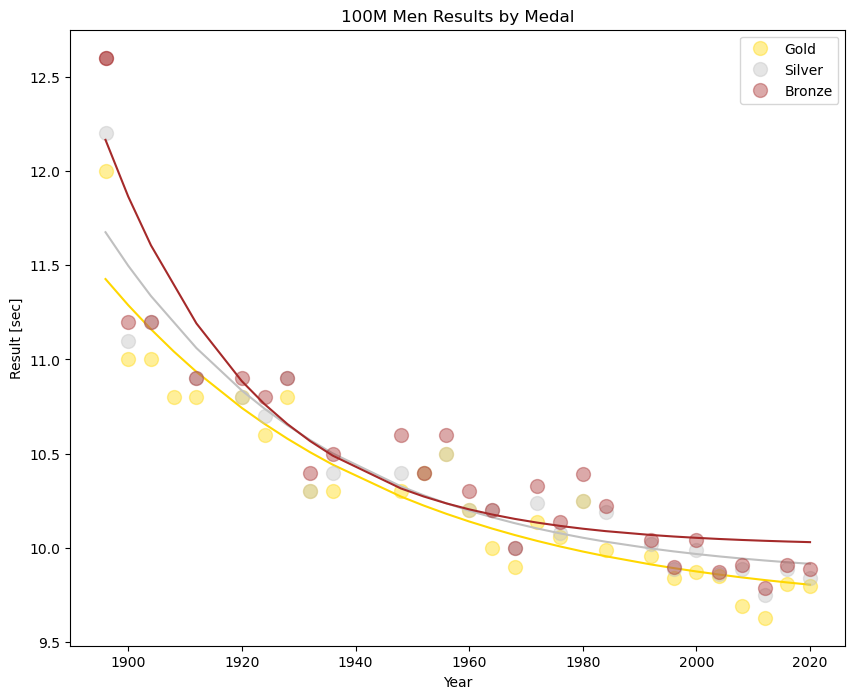

Predicted results for 100M Men in 2024:
Gold Medal: 9.79 seconds
Silver Medal: 9.91 seconds
Bronze Medal: 10.03 seconds


In [11]:
fitted_params, labels = plot_sprint_results(df, '100M Men', exponential_func)
predict_event_results('100M Men', 2024, fitted_params, labels)

In [12]:
top_performers = calculate_top_performers(df, '100M Men', fitted_params)
top_performers

,Name,Year,Medal,Result,expectation,ratio
0,Stanley Rowley,1900,B,11.20,11.863708,1.059260
1,William Hogenson,1904,B,11.20,11.605025,1.036163
2,Walter Tewksbury,1900,S,11.10,11.496807,1.035748
3,Donald Lippincott,1912,B,10.90,11.190943,1.026692
4,Ralph Metcalfe,1932,S,10.30,10.572544,1.026461
5,Frank Jarvis,1900,G,11.00,11.287772,1.026161
6,Justin Gatlin,2012,B,9.79,10.038000,1.025332
7,Reggie Walker,1908,G,10.80,11.042554,1.022459
8,Usain Bolt,2012,G,9.63,9.829849,1.020753
9,Eddie Tolan,1932,G,10.30,10.507868,1.020181


In [13]:
top_performers = get_top_performers_by_medal(df, '100M Men', top_n=10, exclude_years=None)

Top 10 Gold Medalists:
             Name  Year Medal  Result  expectation     ratio
5    Frank Jarvis  1900     G   11.00    11.287772  1.026161
7   Reggie Walker  1908     G   10.80    11.042554  1.022459
8      Usain Bolt  2012     G    9.63     9.829849  1.020753
9     Eddie Tolan  1932     G   10.30    10.507868  1.020181
12      Jim Hines  1968     G    9.90    10.068813  1.017052
15     Usain Bolt  2008     G    9.69     9.843792  1.015871
18    Archie Hahn  1904     G   11.00    11.160139  1.014558


Top 10 Silver Medalists:
                Name  Year Medal  Result  expectation     ratio
2   Walter Tewksbury  1900     S   11.10    11.496807  1.035748
4     Ralph Metcalfe  1932     S   10.30    10.572544  1.026461
10       Yohan Blake  2012     S    9.75     9.933562  1.018827
17       Alvah Meyer  1912     S   10.90    11.060198  1.014697


Top 10 Bronze Medalists:
                 Name  Year Medal  Result  expectation     ratio
0      Stanley Rowley  1900     B   11.20    11.86

## Note about the Model and Early 20th Century Results

In his original work, Goldstein mentions the following:

```
It seems that this metric is biased in favor of runners from the early 20th century. Donovan Bailey broke the world record in the 1996 Olympic games in Atlanta, but is ranked way below many athletes from the very first Olympic games.
```

It's not that I want to discount the results from the early 1900s, but I'm interested to see how the model adjusts itself if those early marks were removed to better improve the model's accuracy for the present and future.

The below is the same foundational code except the following years have been excluded: 1896, 1900, 1904, 1908, and 1912.

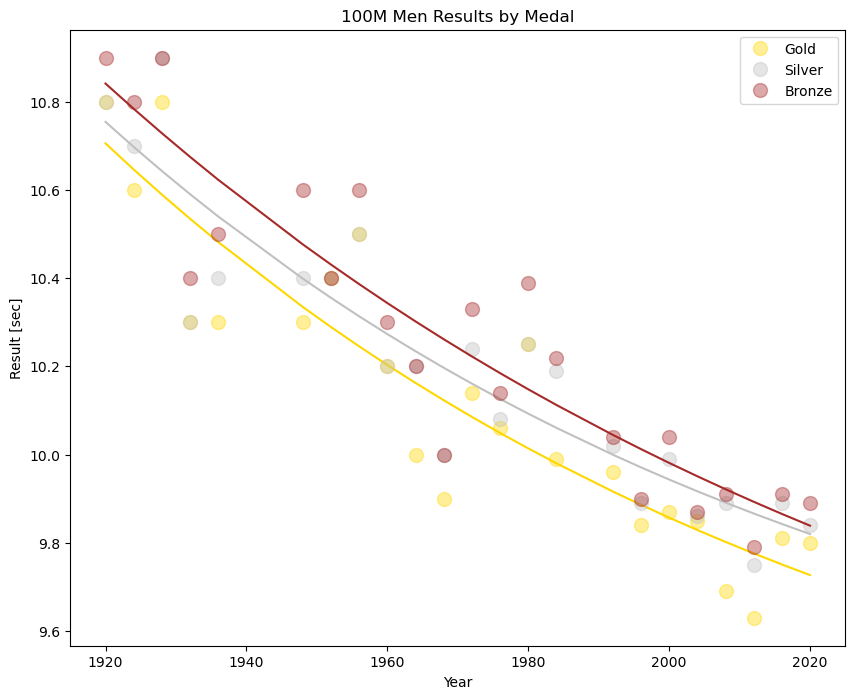

Predicted results for 100M Men in 2024:
Gold Medal: 9.70 seconds
Silver Medal: 9.80 seconds
Bronze Medal: 9.81 seconds


In [14]:
fitted_params, labels = plot_sprint_results(df, '100M Men', exponential_func, omit_years = [1896, 1900, 1904, 1908, 1912])
predict_event_results('100M Men', 2024, fitted_params, labels)

In [15]:
top_performers = calculate_top_performers(df, '100M Men', fitted_params, exclude_years = [1896, 1900, 1904, 1908, 1912])
top_performers

,Name,Year,Medal,Result,expectation,ratio
0,Ralph Metcalfe,1932,S,10.30,10.590591,1.028213
1,Arthur Jonath,1932,B,10.40,10.675172,1.026459
2,Charlie Greene,1968,B,10.00,10.261650,1.026165
3,Eddie Tolan,1932,G,10.30,10.534831,1.022799
4,Jim Hines,1968,G,9.90,10.123262,1.022552
5,Lennox Miller,1968,S,10.00,10.196931,1.019693
6,Jesse Owens,1936,G,10.30,10.481994,1.017669
7,Bob Hayes,1964,G,10.00,10.162476,1.016248
8,Usain Bolt,2012,G,9.63,9.775944,1.015155
9,Ralph Metcalfe,1936,S,10.40,10.539956,1.013457


In [16]:
top_performers = get_top_performers_by_medal(df, '100M Men', top_n=10, exclude_years = [1896, 1900, 1904, 1908, 1912])

Top 10 Gold Medalists:
           Name  Year Medal  Result  expectation     ratio
3   Eddie Tolan  1932     G   10.30    10.534831  1.022799
4     Jim Hines  1968     G    9.90    10.123262  1.022552
6   Jesse Owens  1936     G   10.30    10.481994  1.017669
7     Bob Hayes  1964     G   10.00    10.162476  1.016248
8    Usain Bolt  2012     G    9.63     9.775944  1.015155
12   Usain Bolt  2008     G    9.69     9.801969  1.011555


Top 10 Silver Medalists:
                Name  Year Medal  Result  expectation     ratio
0     Ralph Metcalfe  1932     S   10.30    10.590591  1.028213
5      Lennox Miller  1968     S   10.00    10.196931  1.019693
9     Ralph Metcalfe  1936     S   10.40    10.539956  1.013457
10       Yohan Blake  2012     S    9.75     9.866412  1.011940
16  Frank Fredericks  1996     S    9.89     9.971057  1.008196
18         Dave Sime  1960     S   10.20    10.273224  1.007179
19  Francis Obikwelu  2004     S    9.86     9.916758  1.005756


Top 10 Bronze Medalists

## Analysis and Visualization for 100m Women

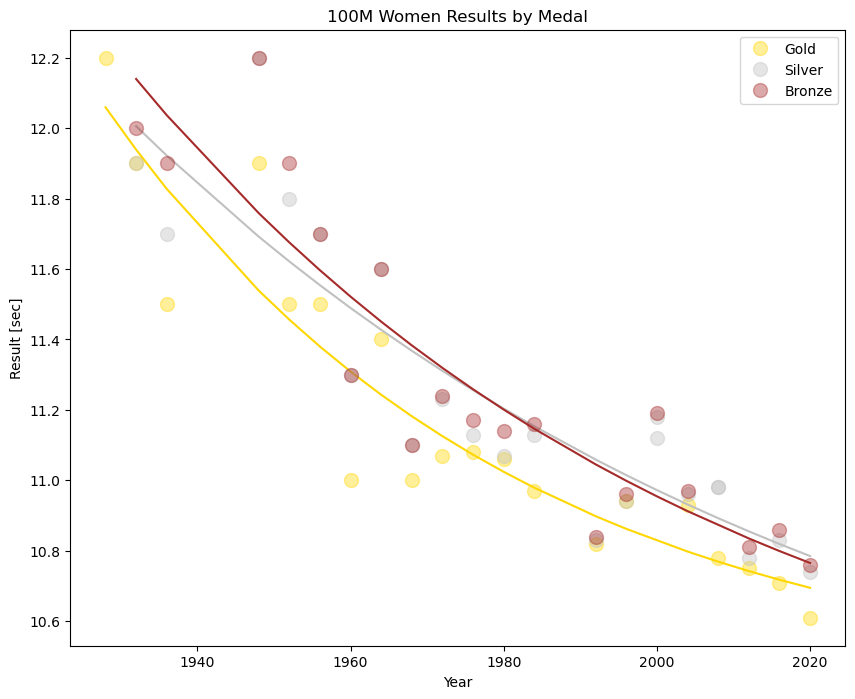

Predicted results for 100M Women in 2024:
Gold Medal: 10.67 seconds
Silver Medal: 10.75 seconds
Bronze Medal: 10.73 seconds


In [17]:
fitted_params, labels = plot_sprint_results(df, '100M Women', exponential_func)
predict_event_results('100M Women', 2024, fitted_params, labels)

In [18]:
top_performers = calculate_top_performers(df, '100M Women', fitted_params)
top_performers

,Name,Year,Medal,Result,expectation,ratio
0,Helen Stephens,1936,G,11.50,11.827443,1.028473
1,Wilma Rudolph,1960,G,11.00,11.308920,1.028084
2,Irena Kirszenstein,1968,B,11.10,11.383195,1.025513
3,Barbara Ferrell,1968,S,11.10,11.367857,1.024131
4,Juliet Cuthbert,1992,S,10.83,11.059110,1.021155
5,Giuseppina Leone,1960,B,11.30,11.521708,1.019620
6,Stanislawa Walasiewicz,1936,S,11.70,11.922165,1.018988
7,Irina Privalova,1992,B,10.84,11.045467,1.018955
8,Dorothy Hyman,1960,S,11.30,11.489411,1.016762
9,Wyomia Tyus,1968,G,11.00,11.182036,1.016549


In [19]:
top_performers = get_top_performers_by_medal(df, '100M Women', top_n=10, exclude_years=None)

Top 10 Gold Medalists:
                     Name  Year Medal  Result  expectation     ratio
0          Helen Stephens  1936     G   11.50    11.827443  1.028473
1           Wilma Rudolph  1960     G   11.00    11.308920  1.028084
9             Wyomia Tyus  1968     G   11.00    11.182036  1.016549
15  Elaine Thompson-Herah  2020     G   10.61    10.694948  1.008006
17            Gail Devers  1992     G   10.82    10.898338  1.007240


Top 10 Silver Medalists:
                      Name  Year Medal  Result  expectation     ratio
3          Barbara Ferrell  1968     S   11.10    11.367857  1.024131
4          Juliet Cuthbert  1992     S   10.83    11.059110  1.021155
6   Stanislawa Walasiewicz  1936     S   11.70    11.922165  1.018988
8            Dorothy Hyman  1960     S   11.30    11.489411  1.016762
10   Marlies Oelsner-GãHr  1980     S   11.07    11.203723  1.012080
13          Renate Stecher  1976     S   11.13    11.256142  1.011334
14            Hilda Strike  1932     S   11.90

## Note about the Model and Early 20th Century Results

Again, the model is favoring results from earlier Olympic races. So in an effort to improve the overall implentation of the model, I have the same code below except with the years 1932 and 1936 excluded from the function.

However, when those years were excluded from the model, the predicted results for 2024 seem *less accurate* for Silver and Bronze while result for Gold remained the same.

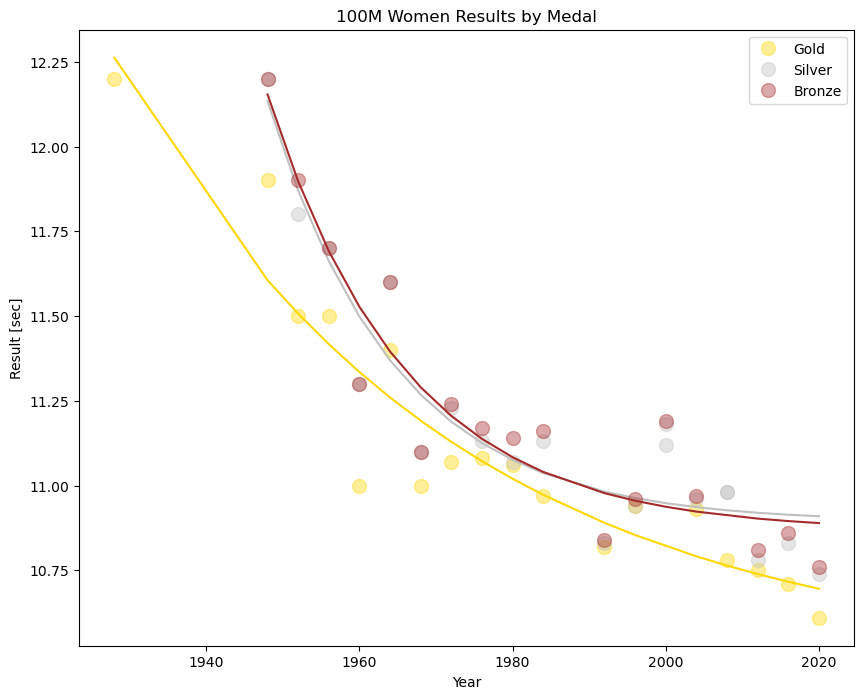

Predicted results for 100M Women in 2024:
Gold Medal: 10.68 seconds
Silver Medal: 10.91 seconds
Bronze Medal: 10.88 seconds


In [20]:
fitted_params, labels = plot_sprint_results(df, '100M Women', exponential_func, omit_years = [1932, 1936])
predict_event_results('100M Women', 2024, fitted_params, labels)

In [21]:
top_performers = calculate_top_performers(df, '100M Women', fitted_params, exclude_years=[1932, 1936])
top_performers

,Name,Year,Medal,Result,expectation,ratio
0,Wilma Rudolph,1960,G,11.00,11.334702,1.030427
1,Giuseppina Leone,1960,B,11.30,11.527010,1.020089
2,Dorothy Hyman,1960,S,11.30,11.498129,1.017534
3,Wyomia Tyus,1968,G,11.00,11.191274,1.017389
4,Irena Kirszenstein,1968,B,11.10,11.289746,1.017094
5,Shelly-Ann Fraser-Pryce,2020,S,10.74,10.909359,1.015769
6,Barbara Ferrell,1968,S,11.10,11.267888,1.015125
7,Juliet Cuthbert,1992,S,10.83,10.981950,1.014031
8,Carmelita Jeter,2012,S,10.78,10.919630,1.012953
9,Irina Privalova,1992,B,10.84,10.977443,1.012679


In [22]:
top_performers = get_top_performers_by_medal(df, '100M Women', top_n=10, exclude_years = [1932, 1936])

Top 10 Gold Medalists:
                     Name  Year Medal  Result  expectation     ratio
0           Wilma Rudolph  1960     G   11.00    11.334702  1.030427
3             Wyomia Tyus  1968     G   11.00    11.191274  1.017389
12  Elaine Thompson-Herah  2020     G   10.61    10.695435  1.008052
14            Gail Devers  1992     G   10.82    10.889895  1.006460
16         Renate Stecher  1972     G   11.07    11.128854  1.005317
17     Elizabeth Robinson  1928     G   12.20    12.261933  1.005076


Top 10 Silver Medalists:
                       Name  Year Medal  Result  expectation     ratio
2             Dorothy Hyman  1960     S   11.30    11.498129  1.017534
5   Shelly-Ann Fraser-Pryce  2020     S   10.74    10.909359  1.015769
6           Barbara Ferrell  1968     S   11.10    11.267888  1.015125
7           Juliet Cuthbert  1992     S   10.83    10.981950  1.014031
8           Carmelita Jeter  2012     S   10.78    10.919630  1.012953
13               Tori Bowie  2016     S  

## Analysis and Visualization for 200m Men

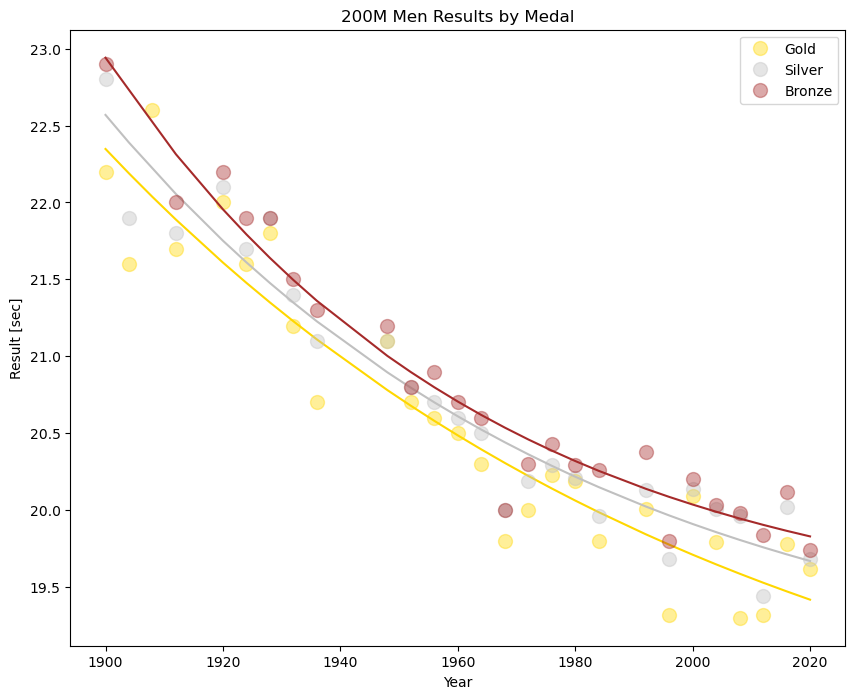

Predicted results for 200M Men in 2024:
Gold Medal: 19.37 seconds
Silver Medal: 19.63 seconds
Bronze Medal: 19.79 seconds


In [23]:
fitted_params, labels = plot_sprint_results(df, '200M Men', exponential_func)
predict_event_results('200M Men', 2024, fitted_params, labels)

In [24]:
top_performers = calculate_top_performers(df, '200M Men', fitted_params)
top_performers

,Name,Year,Medal,Result,expectation,ratio
0,Archie Hahn,1904,G,21.60,22.189015,1.027269
1,John Carlos,1968,B,20.00,20.536355,1.026818
2,Tommie Smith,1968,G,19.80,20.306726,1.025592
3,Michael Johnson,1996,G,19.32,19.775207,1.023561
4,Nate Cartmell,1904,S,21.90,22.389290,1.022342
5,Peter Norman,1968,S,20.00,20.440992,1.022050
6,Jesse Owens,1936,G,20.70,21.109420,1.019779
7,Yohan Blake,2012,S,19.44,19.758058,1.016361
8,Usain Bolt,2008,G,19.30,19.586362,1.014837
9,Frank Fredericks,1996,S,19.68,19.965154,1.014490


In [25]:
top_performers = get_top_performers_by_medal(df, '200M Men', top_n=10, exclude_years=None)

Top 10 Gold Medalists:
               Name  Year Medal  Result  expectation     ratio
0       Archie Hahn  1904     G   21.60    22.189015  1.027269
2      Tommie Smith  1968     G   19.80    20.306726  1.025592
3   Michael Johnson  1996     G   19.32    19.775207  1.023561
6       Jesse Owens  1936     G   20.70    21.109420  1.019779
8        Usain Bolt  2008     G   19.30    19.586362  1.014837
13    Valery Borzov  1972     G   20.00    20.222102  1.011105
14       Usain Bolt  2012     G   19.32    19.527936  1.010763
16       Carl Lewis  1984     G   19.80    19.986250  1.009407
17      Ralph Craig  1912     G   21.70    21.888422  1.008683


Top 10 Silver Medalists:
                 Name  Year Medal  Result  expectation     ratio
4       Nate Cartmell  1904     S   21.90    22.389290  1.022342
5        Peter Norman  1968     S   20.00    20.440992  1.022050
7         Yohan Blake  2012     S   19.44    19.758058  1.016361
9    Frank Fredericks  1996     S   19.68    19.965154  1.01

In [26]:
top_performers = calculate_top_performers(df, '200M Men', fitted_params, exclude_years=[1900, 1904])
top_performers

,Name,Year,Medal,Result,expectation,ratio
0,John Carlos,1968,B,20.00,20.536355,1.026818
1,Tommie Smith,1968,G,19.80,20.306726,1.025592
2,Michael Johnson,1996,G,19.32,19.775207,1.023561
3,Peter Norman,1968,S,20.00,20.440992,1.022050
4,Jesse Owens,1936,G,20.70,21.109420,1.019779
5,Yohan Blake,2012,S,19.44,19.758058,1.016361
6,Usain Bolt,2008,G,19.30,19.586362,1.014837
7,Frank Fredericks,1996,S,19.68,19.965154,1.014490
8,Ato Boldon,1996,B,19.80,20.085714,1.014430
9,William Applegarth,1912,B,22.00,22.313226,1.014238


In [27]:
top_performers = get_top_performers_by_medal(df, '200M Men', top_n=10, exclude_years=[1900, 1904])

Top 10 Gold Medalists:
               Name  Year Medal  Result  expectation     ratio
1   Michael Johnson  1996     G   19.32    19.762365  1.022897
2      Tommie Smith  1968     G   19.80    20.242322  1.022340
3       Ralph Craig  1912     G   21.70    22.175042  1.021891
5       Jesse Owens  1936     G   20.70    21.132809  1.020909
8        Usain Bolt  2008     G   19.30    19.614216  1.016281
12       Usain Bolt  2012     G   19.32    19.570849  1.012984
14    Valery Borzov  1972     G   20.00    20.159861  1.007993
17       Carl Lewis  1984     G   19.80    19.942014  1.007172


Top 10 Silver Medalists:
                          Name  Year Medal  Result  expectation     ratio
4                 Peter Norman  1968     S   20.00    20.418287  1.020914
6            Donald Lippincott  1912     S   21.80    22.192058  1.017984
7                  Yohan Blake  2012     S   19.44    19.771608  1.017058
11            Frank Fredericks  1996     S   19.68    19.958862  1.014170
13           

## Analysis and Visualization for 200m Women

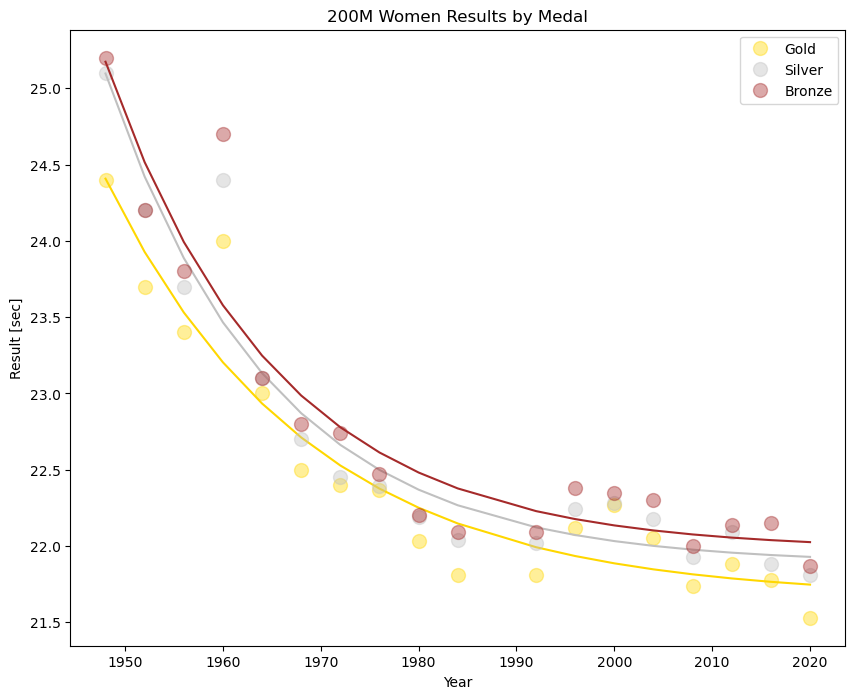

Predicted results for 200M Women in 2024:
Gold Medal: 21.73 seconds
Silver Medal: 21.92 seconds
Bronze Medal: 22.01 seconds


In [28]:
fitted_params, labels = plot_sprint_results(df, '200M Women', exponential_func)
predict_event_results('200M Women', 2024, fitted_params, labels)

In [29]:
top_performers = calculate_top_performers(df, '200M Women', fitted_params)
top_performers

,Name,Year,Medal,Result,expectation,ratio
0,Valerie Brisco,1984,G,21.81,22.147644,1.015481
1,Nadezhda Khnykina,1952,B,24.20,24.515551,1.013039
2,Merlene Ottey,1984,B,22.09,22.377247,1.013003
3,Merlene Ottey,1980,B,22.20,22.481491,1.012680
4,Florence GRIFFITH Joyner,1984,S,22.04,22.266887,1.010294
5,Elaine Thompson-Herah,2020,G,21.53,21.747043,1.010081
6,BÃ¤rbel Eckert-WãCkel,1980,G,22.03,22.250845,1.010025
7,Marjorie Jackson,1952,G,23.70,23.927064,1.009581
8,Raelene Ann Boyle,1972,S,22.45,22.662571,1.009469
9,Irena Kirszenstein,1968,G,22.50,22.711212,1.009387


In [30]:
top_performers = get_top_performers_by_medal(df, '200M Women', top_n=10, exclude_years=None)

Top 10 Gold Medalists:
                      Name  Year Medal  Result  expectation     ratio
0           Valerie Brisco  1984     G   21.81    22.147644  1.015481
5    Elaine Thompson-Herah  2020     G   21.53    21.747043  1.010081
6   BÃ¤rbel Eckert-WãCkel  1980     G   22.03    22.250845  1.010025
7         Marjorie Jackson  1952     G   23.70    23.927064  1.009581
9       Irena Kirszenstein  1968     G   22.50    22.711212  1.009387
11           Gwen Torrence  1992     G   21.81    21.992229  1.008355


Top 10 Silver Medalists:
                        Name  Year Medal  Result  expectation     ratio
4   Florence GRIFFITH Joyner  1984     S   22.04    22.266887  1.010294
8          Raelene Ann Boyle  1972     S   22.45    22.662571  1.009469
10            Bertha Brouwer  1952     S   24.20    24.420850  1.009126
14           Natalia Bochina  1980     S   22.19    22.369145  1.008073
15          Christa Stubnick  1956     S   23.70    23.887250  1.007901
16         Raelene Ann Boyle

## Conclusions

### Overall Model
Based on the historical data, the model performed pretty well in terms of ranking which athletes overperformed their predicted result. In all four events, the model did favor results from the early and mid 1900s, which may be because there was no data or races prior to those dates.

It's really interesting to note that the sprinters that overperformed their expected result the most weren't gold medalists, but silver and bronze medalists. My thinking is that even though some gold medalists like Usain Bolt or Michael Johnson ran all-time great races, it was the sprinters behind them that were trying to catch these legends that overperformed *more* than those running from the front.